In [99]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
def idft(H, w):
    # N = len(H)
    # n = np.arange(N)
    # h = np.zeros(N, dtype=complex)
    # for i in range(N):
    #     for j in range(N):
    #         h[i] += H[j] * np.exp(1j * w[j] * i) / N
    
    # return h.real, n
    h = np.fft.ifft(H)
    h = np.fft.ifftshift(h)
    n = np.arange(len(h))
    return h, n



In [101]:
def dft(h):
    N = len(h)
    H = np.fft.fft(h)
    w = np.fft.fftfreq(N)
    return H , w

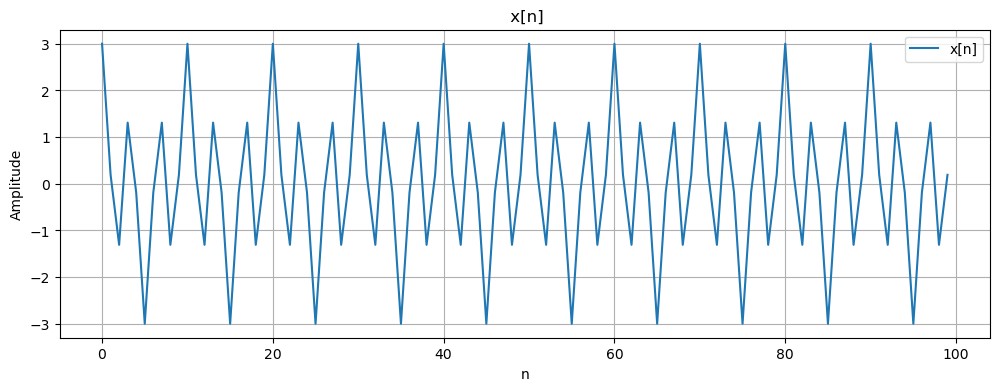

In [102]:
# Step 2: 定义信号 x[n]
A1, A2 = 1, 2  # 幅值
f1, f2 = 0.1, 0.3  # 频率
T = 1
fs = 1
N_sampls = 100
n = np.linspace(0, (N_sampls - 1) * T, N_sampls)  # 时间序列 n = 0:99

# 生成信号
x = A1 * np.cos(2 * np.pi * f1 * n) + A2 * np.cos(2 * np.pi * f2 * n)

# 绘制时域信号 x[n]
plt.figure(figsize=(12, 4))
plt.plot(n, x, label='x[n]')
plt.title(' x[n]')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


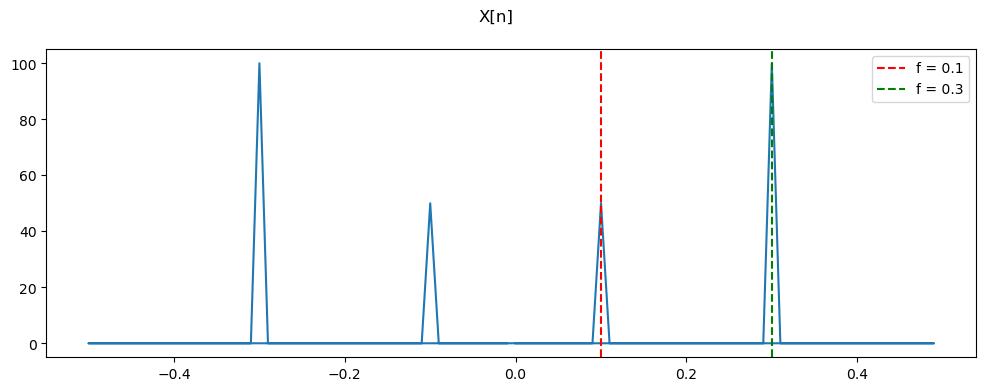

In [103]:
X, w = dft(x)

plt.figure(figsize=(12, 4))

plt.suptitle("X[n]")

plt.plot(w * fs, np.abs(X))
plt.axvline(x=0.1, color='r', linestyle='--', label=f'f = {0.1}')
plt.axvline(x=0.3, color='g', linestyle='--', label=f'f = {0.3}')

plt.legend()

In [104]:
from scipy import signal

def cheby_filter_scipy(N, rp, rs, Wn, btype='low', analog=False):
    """
    使用scipy实现切比雪夫滤波器
    N: 滤波器阶数
    rp: 通带纹波(dB)
    rs: 阻带衰减(dB)
    Wn: 截止频率
    btype: 滤波器类型 ('low', 'high', 'band', 'stop')
    analog: 是否为模拟滤波器
    """
    b, a = signal.cheby2(N, rs, Wn, btype=btype, analog=analog,  output='ba')
    return b, a

In [105]:
# 设计滤波器参数
nyq = fs / 2  # 奈奎斯特频率
order = 2      # 滤波器阶数
rs = 10    # 阻带衰减
fc = 0.245
Wn = fc / nyq  # 截止频率

# 使用手动方法设计滤波器
b_s, a_s = cheby_filter_scipy(order, None, rs, Wn)
y_s = signal.filtfilt(b_s, a_s, x)

In [106]:
# Step 4: 双线性变换

# 转换公式
b_z = b_s * (2 / T)
a_z = a_s * (2 / T)

# 打印数字滤波器系数
print("数字滤波器的分子系数 b_z:", b_z)
print("数字滤波器的分母系数 a_z:", a_z)


数字滤波器的分子系数 b_z: [0.72953802 0.44518924 0.72953802]
数字滤波器的分母系数 a_z: [ 2.         -0.65096315  0.55522842]


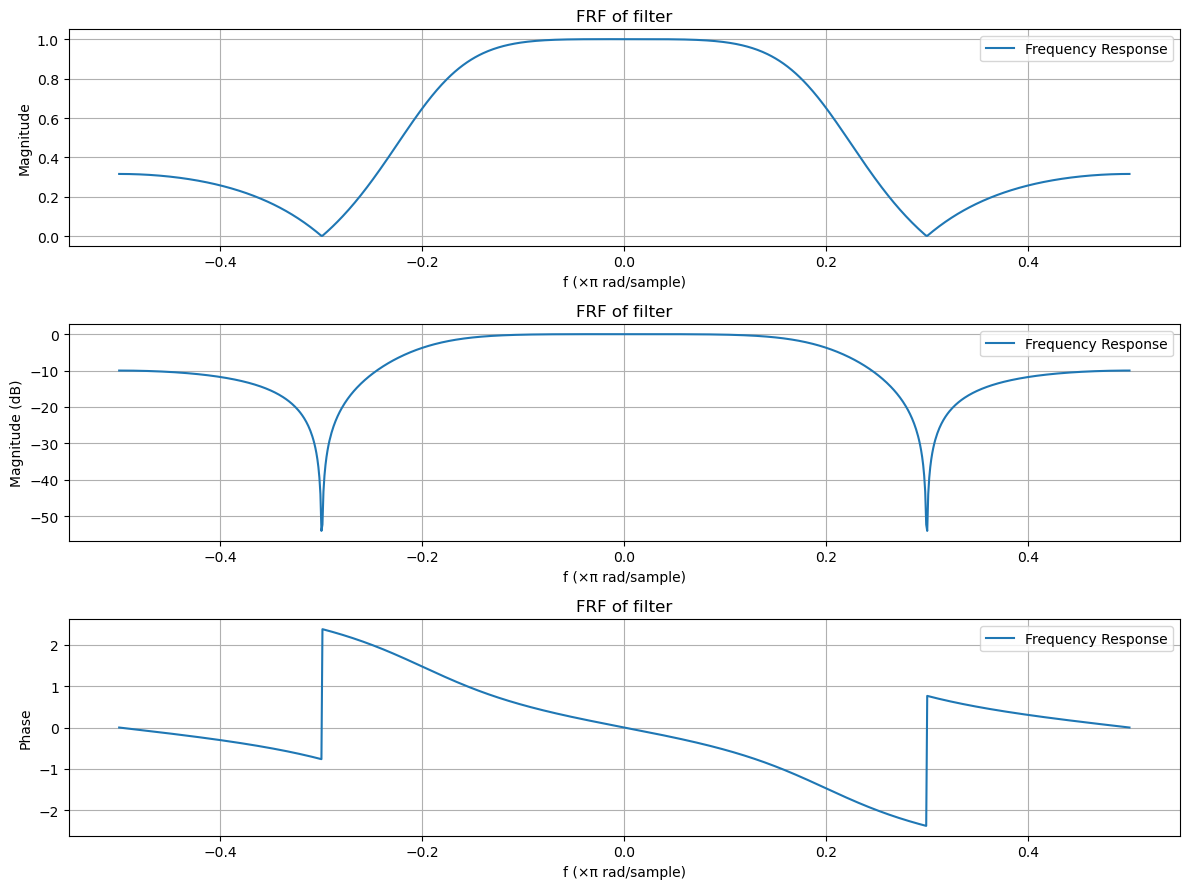

In [107]:
# Step 5: 计算频率响应
def frequency_response(b, a, w):
    jw = np.exp(-1j * w)
    num = np.polyval(b[::-1], jw)
    den = np.polyval(a[::-1], jw)
    H = num / den
    return H

w = np.linspace(-np.pi, np.pi, 1000)
H = frequency_response(b_z, a_z, w)

# 绘制频率响应
plt.figure(figsize=(12, 9))

plt.subplot(311)
#plt.plot(w / 2 / np.pi, 20 * np.log10(np.abs(H)), label='Frequency Response')
plt.plot(w / 2 / np.pi, np.abs(H), label='Frequency Response')
plt.title('FRF of filter')
plt.xlabel('f (×π rad/sample)')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

plt.subplot(312)
plt.plot(w / 2 / np.pi, 20 * np.log10(np.abs(H)), label='Frequency Response')
# plt.plot(w / 2 / np.pi, np.abs(H), label='Frequency Response')
plt.title('FRF of filter')
plt.xlabel('f (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()

plt.subplot(313)
plt.plot(w / 2 / np.pi, np.angle(H), label='Frequency Response')
# plt.plot(w / 2 / np.pi, np.abs(H), label='Frequency Response')
plt.title('FRF of filter')
plt.xlabel('f (×π rad/sample)')
plt.ylabel('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [108]:
def filter(bz, az, x, L):
    """
    `bz` and `az` is the coefficients of the difference equation.
    For the input signal x, this function will calculate first L terms of the output signal y.

    ## Examples

    ```py
    bz = [2, 3]
    az = [1, -0.5]
    L = 100
    xs = [1, 2, 3]
    xs, ys = filter(bz, az, xs, L)  # first several inputs
    debug_draw(np.arange(L), ys, label="Outputs")
    ```
    """
    def expand(arr, n):
        return np.pad(arr, (0, n - len(arr)), 'constant')
    xs = expand(x, L)
    ys = np.zeros_like(xs)

    def y_at(n):
        return 0 if n < 0 else ys[n]

    def x_at(n):
        return 0 if n < 0 else xs[n]
    for n in range(L):
        ys[n] = sum([bz[i] * x_at(n - i) for i in range(len(bz))]) - \
            sum([az[i] * y_at(n - i) for i in range(1, len(az))])
    return xs, ys

In [109]:
# Step 6: 定义myfilter函数
def myfilter(b, a, x):
    L = len(x)
    xs, ys = filter(b, a, x, L)
    return ys
    y = np.zeros(len(x))
    for n in range(len(x)):
        y[n] = b[0] * x[n]
        if n >= 1:
            y[n] += b[1] * x[n - 1] - a[1] * y[n - 1]
        if n >= 2:
            y[n] += b[2] * x[n - 2] - a[2] * y[n - 2]
    return y


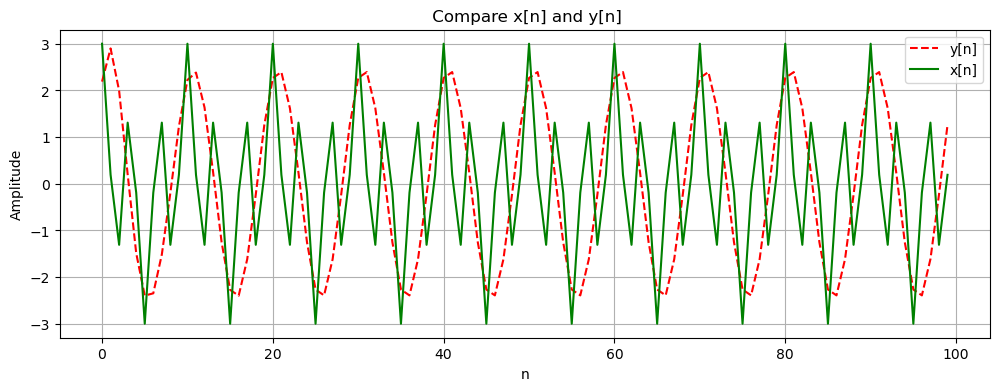

In [110]:
# Step 7: 使用 myfilter 滤波信号 x[n]
y = myfilter(b_z, a_z, x)

# 绘制滤波后的时域信号 y[n]
plt.figure(figsize=(12, 4))
plt.plot(n, y, label='y[n]', color = 'red', linestyle = '--')
plt.plot(n, x, label = 'x[n]', color = 'green')
plt.title(' Compare x[n] and y[n]')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


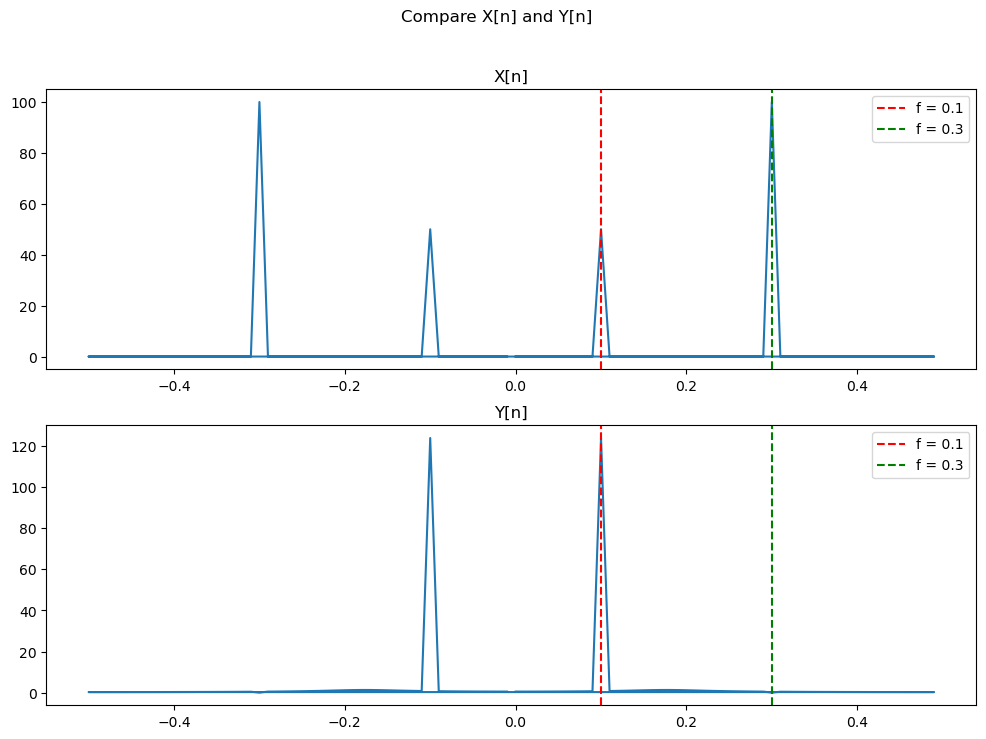

In [111]:
Y, w = dft(y)

plt.figure(figsize=(12, 8))

plt.suptitle("Compare X[n] and Y[n]")

plt.subplot(211)
plt.title("X[n]")
plt.plot(w * fs, np.abs(X))
plt.axvline(x=0.1, color='r', linestyle='--', label=f'f = {0.1}')
plt.axvline(x=0.3, color='g', linestyle='--', label=f'f = {0.3}')

plt.legend()

plt.subplot(212)
plt.title("Y[n]")

plt.plot(w * fs, np.abs(Y))
plt.axvline(x=0.1, color='r', linestyle='--', label=f'f = {0.1}')
plt.axvline(x=0.3, color='g', linestyle='--', label=f'f = {0.3}')

plt.legend()

C:\Users\Modes\AppData\Local\Temp\ipykernel_22016\2852742430.py:25: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Modes\AppData\Local\Temp\ipykernel_22016\2852742430.py:25: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Modes\AppData\Local\Temp\ipykernel_22016\2852742430.py:25: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Modes\AppData\Local\Temp\ipykernel_22016\2852742430.py:25: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Modes\AppData\Local\Temp\ipykernel_22016\2852742430.py:25: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Modes\AppData\Local\Temp\ipykernel_22016\2852742430.py:25: UserWarning: Glyph 39057 (\

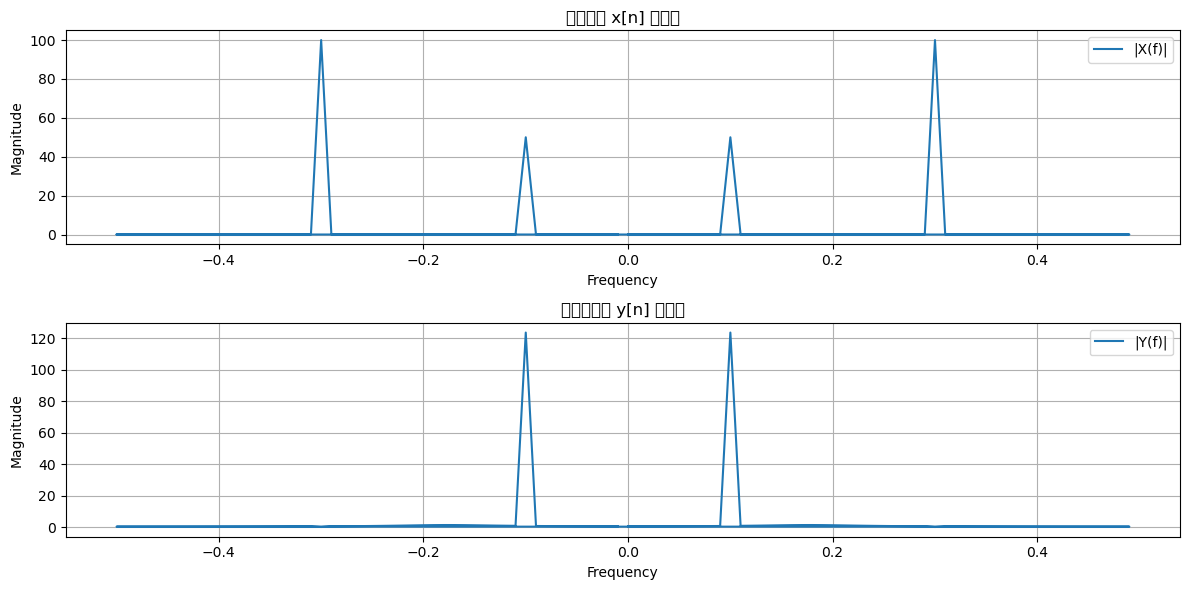

In [112]:
# Step 8: 计算频谱并绘制
X = np.fft.fft(x)
Y = np.fft.fft(y)
freq = np.fft.fftfreq(len(n), d=1)

# 绘制原信号和滤波信号的频谱
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(freq, np.abs(X), label='|X(f)|')
plt.title('原始信号 x[n] 的频谱')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(Y), label='|Y(f)|')
plt.title('滤波后信号 y[n] 的频谱')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
